# The Boolean Pandemic
## Who is more likely to survive to the boolean pandemic?

# Setup Environment
Before running this notebook, the user needs to configure a separate conda environment in order to reproduce the results obtained. An **environment.yml** file is provided in the project submission zip file with this objective. By creating a conda environment through the yml file, the user will be able to run the whole project without issues.

In order to create the environment the user needs to run the following commands in the anaconda prompt: conda `env create -f <path to environment.yml>`. Afterwards, the user needs to activate the created environment: `conda activate ml` and initialize the jupyter notebook: `jupyter notebook`.

# Overview
On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a **predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?”** using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can **predict if a patient will survive, or not**, to the boolean pandemic?

# Objective
The goal of your team is to predict if a patient is going to survive, or not, on the test set by using the model you created on the training set. The score of your predictions is the percentage of instances you correctly predict, using the **accuracy**. You are allowed to apply any kind of classifier!

# Evaluation
The project will be evaluated taking into account the following criteria:
- Model accuracy;
- The quality of the data exploration, pre-processing, modelling and assessment steps;
- Contributions based on self-study and creativity will be valued;
- The notebook structure and the conclusions / insights / review / justification of techniques of the developed processes in each of the stages of the process. For example, after the data exploration phase, you should write down at the end of this topic in markdown the main insights that you gather from the data during this phase.

# Deliverables
You should submit a csv file with the number of instances in the test set, containing the columns [Patient_ID, Deceased], and only those columns. The Deceased column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

# Metadata (corrected)
- *Patient_ID* - The unique identifier of the patient
- *Family_Case_ID* - The family identification
- *Severity* - The severity of the disease, where 1 is the lowest and 3 the highest severity
- *Name* - The name of the patient
- *Birthday_year* - The year of birthday of the patient
- *Parents_Children_Infected* - The number of parents and/or children infected
- *Partner_Siblings_Infected* - The number of partner and/or siblings infected
- *Medical_Expenses_Family* - The medical expenses associated to try to contain the epidemy on the family
- *Medical_Tent* - The medical tent where the patient is / was lodged
- *City* - The original city of the patient
- *Deceased* - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

# Import Packages and Data

In [1]:
import zipfile as zp
import time
from math import ceil
from joblib import dump, load
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
warnings.filterwarnings("ignore")
# from sklearn import set_config
# set_config(display='diagram')   

In [2]:
df_list = []
for file in ["train.csv", "test.csv"]:
    with zp.ZipFile("./data.zip") as myzip:
        with myzip.open(file) as myfile:
            df_list.append(pd.read_csv(myfile))
            
train_df, test_df = df_list

# Data Assessment

In [3]:
print('There are ', train_df.shape[0], 'rows and ', train_df.shape[1], 'columns on the train set.')
print('There are ', test_df.shape[0], 'rows and ', test_df.shape[1], 'columns on the test set.')

There are  900 rows and  11 columns on the train set.
There are  400 rows and  10 columns on the test set.


Renaming some variables to make the code easier to write.

In [4]:
# Correcting variables
train_df.rename({"Parents or siblings infected": "Parents_Children_Infected", 
                 "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)
test_df.rename({"Parents or siblings infected": "Parents_Children_Infected", 
                "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)

In [5]:
train_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [6]:
test_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


### Duplicates
No duplicates

In [7]:
# Check duplicates with all columns
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [8]:
# Check duplicates excluding Patient_ID
train_df.duplicated(subset=train_df.columns[1:]).sum(), test_df.duplicated(subset=test_df.columns[1:]).sum()

(0, 0)

In [9]:
# Check duplicates excluding Patient_id and Family_Case_ID
train_df.duplicated(subset=train_df.columns[2:]).sum(), test_df.duplicated(subset=test_df.columns[2:]).sum()

(0, 0)

In [10]:
# Check duplicates excluding Patient_id and Family_Case_ID and City
train_df.duplicated(subset=train_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum(),\
test_df.duplicated(subset=test_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum()

(0, 0)

### Index and Data Types

In [11]:
train_df.set_index("Patient_ID", inplace=True)
test_df.set_index("Patient_ID", inplace=True)

In [12]:
train_df.dtypes

Family_Case_ID                 int64
Severity                       int64
Name                          object
Birthday_year                float64
Parents_Children_Infected      int64
Partner_Siblings_Infected      int64
Medical_Expenses_Family        int64
Medical_Tent                  object
City                          object
Deceased                       int64
dtype: object

### Numerical Statistics

In [13]:
descriptive = train_df.describe().T
descriptive['nulls'] = train_df.shape[0] - descriptive['count']
descriptive

,count,mean,std,min,25%,50%,75%,max,nulls
Family_Case_ID,900.0,14305.827778,25418.153900,345.0,8203.0,13593.5,18906.50,742836.0,0.0
Severity,900.0,2.313333,0.834223,1.0,2.0,3.0,3.00,3.0,0.0
Birthday_year,723.0,1990.266943,14.523335,1940.0,1982.0,1992.0,1999.50,2019.0,177.0
Parents_Children_Infected,900.0,0.380000,0.803247,0.0,0.0,0.0,0.00,6.0,0.0
Partner_Siblings_Infected,900.0,0.521111,1.098385,0.0,0.0,0.0,1.00,8.0,0.0
Medical_Expenses_Family,900.0,895.743333,1385.829926,0.0,221.0,405.0,861.25,14345.0,0.0
Deceased,900.0,0.614444,0.486997,0.0,0.0,1.0,1.00,1.0,0.0


- Outliers: Medical_Expenses_Family, Partner_Siblings_Infected, Parents_Children_Infected
- Transform Birthday_year in Age
- Nulls: Birthday_year

### Categorical Statistics

In [14]:
descriptive = train_df[['Name','Medical_Tent', 'City']].describe().T
descriptive['nulls'] = train_df[['Name','Medical_Tent', 'City']].shape[0] - descriptive['count']
descriptive

,count,unique,top,freq,nulls
Name,900,899,Mr. Samuel Darnell,2,0
Medical_Tent,198,8,C,57,702
City,898,3,Santa Fe,649,2


- Name might not seem valueable, however we can analyze titles to find out features such as gender, married, etc.
- Maybe the nulls in Medical_Tent mean that they treated the disease at home or the tent is just not known (maybe replace nulls by "Home" or "NotKnown" and assess its discriminancy according to the target)

In [15]:
train_df.isna().sum(axis=1).value_counts()

1    565
0    177
2    158
dtype: int64

### Label Counts
Balanced dataset

In [16]:
train_df['Deceased'].value_counts()

1    553
0    347
Name: Deceased, dtype: int64

# Data Exploration

##### Family Size Frequency

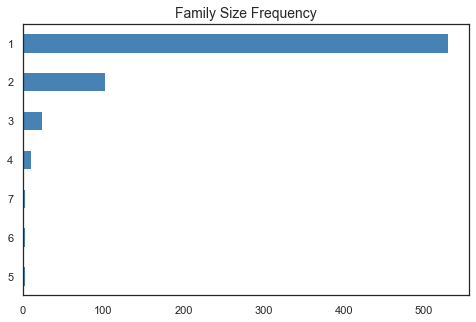

In [17]:
# Data leakage by ignoring family relationships? Familiar relationships make that observations in test set might not be independent from ones in the training set.
# Candidate for GroupKFold and GroupSplit.
sns.set(style="white")

plt.figure(figsize=(8, 5))
train_df["Family_Case_ID"].value_counts().value_counts(ascending=True).plot(kind="barh", color='steelblue')
plt.title("Family Size Frequency", fontsize=14)
plt.show()

We can see above that we have several individuals from the same family in our data. This can potentially cause some leakage if our data partitions (train-test split and cross-validation) don't preserve the individuals from the same family in the same partition, which in turn would lead to a biased estimate of the generalization capability of the model on the test set. However, it is also possible that after deployment we may find a relative of one of the patients used to train the model, which justifies the non-necessity of doing a constraint data partition process, as relatives in the test set represent a common situation in the real world.

**Train-test split:** Our dataset has 900 observations and applying train-test split, considering a ratio of 90/10, we would end up with 90 observations for test and 810 for training, assessing performance in only 90 observations. This wouldn't be a very good measure of the model generalization. Therefore and having in mind that the kaggle dataset has 400 observations , we can use it as a test set, assessing the performance in it but do not tune the model according to it. To do so, we decided to use cross validation, comparing model performances and tuning the models.

In [18]:
# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City", "Deceased"]  # categorical variables
metric_features = train_df.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list() + ["Deceased"]  # metric variables

##### Explore Numerical Variables by Target

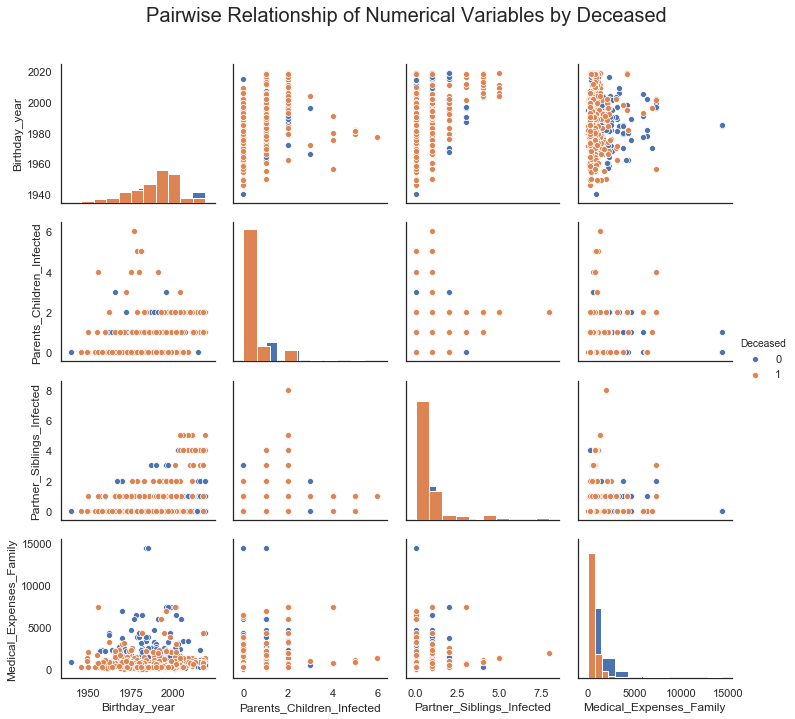

In [19]:
# data to plot
sns.set(style="white")

# Setting pairgrid
g = sns.pairplot(train_df[metric_features], hue="Deceased", diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.9)
plt.suptitle("Pairwise Relationship of Numerical Variables by Deceased", fontsize=20)
plt.show()

- Partner_Siblings_Infected and Parents_Children_Infected have low cardinalities, we will have to analyze these in detail
- As previously discussed, Medical_Expenses Family has outliers

In [20]:
def box_plot_numerical(df, features, title):
    # Prepare figure
    fig, axes = plt.subplots(1, len(features), figsize=(12, 4), constrained_layout=True)

    # Plot data
    for ax, f in zip(axes.flatten(), features):
        sns.boxplot(y=f, data=df, ax=ax, x='Deceased')
        ax.set_title(f)
        ax.set_ylabel('') 
        
    # Layout
    plt.suptitle(title, fontsize=16)
    plt.show()

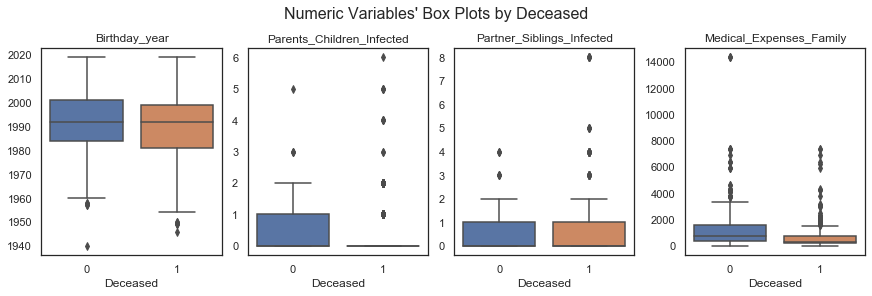

In [21]:
title = "Numeric Variables' Box Plots by Deceased"

# features to plot
plot_features = metric_features
plot_features.remove("Deceased")

box_plot_numerical(train_df, plot_features, title)

- Once again, we can clearly conclude that Medical_Expenses_Family has outliers but this can be explained by the fact that this variable is the total expenses by family and not individually. We should **normalize this variable by the number of family members** having a better and more precise view of this variable.
- Although it seems that Partner_Siblings_Infected and Parents_Children_Infected have outliers, we do not consider them as it because this only happens due to the low expressiveness of the higher values which can be bypassed creating a binary or even a categorical variable with only 3 categories (**aggregate categories with low expressiveness**).

##### Explore Categorical and Low Cardinality Variables by Target

In [22]:
def categorical_cardinality_plot(df, features, title):
    # figure and axes
    fig, axes = plt.subplots(2, ceil(len(features)/2), figsize=(20,10))

    # plot data
    for ax, x in zip(axes.flatten(), features):
        if x == "Deceased":
            sns.countplot(x=x, hue="Deceased", order=[0, 1], data=df, ax=ax)
        else:
            sns.countplot(x=x, hue="Deceased", data=df, ax=ax)
        ax.get_legend().remove()

    # Set legend (Deceased)
    handles, _ = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, ["Non-Deceased", "Deceased"], loc=(0.07,0.91), title="Deceased", title_fontsize=12)

    plt.subplots_adjust(wspace=0.25)
    plt.suptitle(title, y=0.95, fontsize=20)

    plt.show()

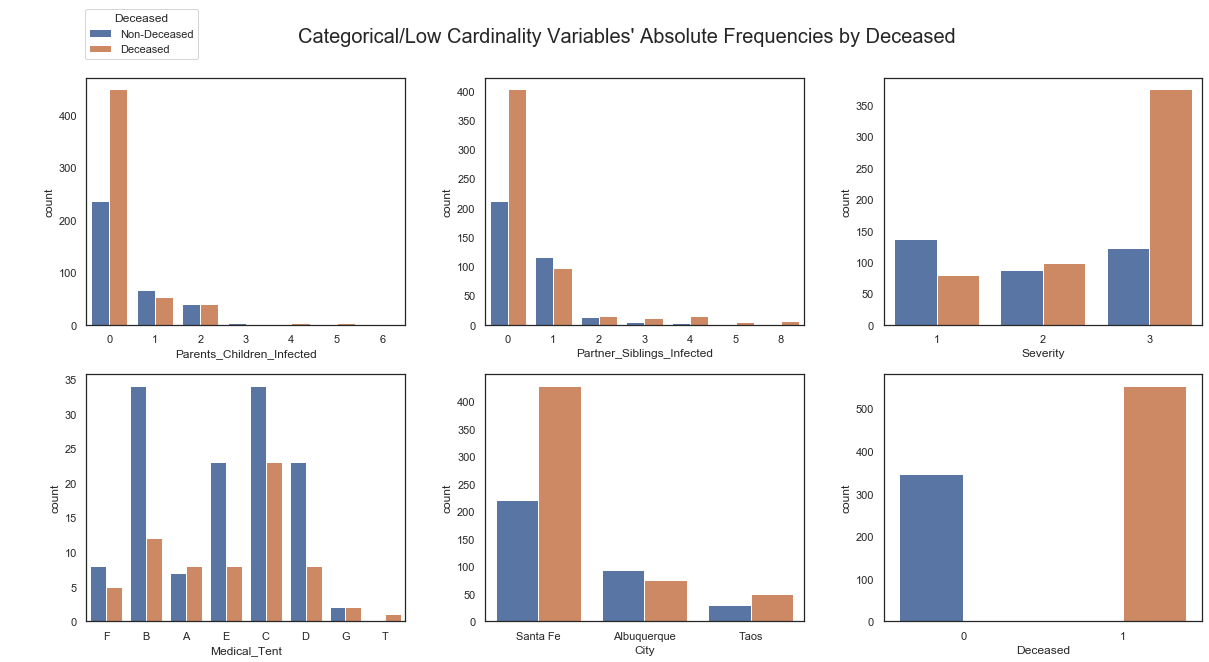

In [23]:
title = "Categorical/Low Cardinality Variables' Absolute Frequencies by Deceased"
# data to plot
plot_df = train_df[lc_c_features + ["Parents_Children_Infected", "Partner_Siblings_Infected"]]
plot_features = ["Parents_Children_Infected", "Partner_Siblings_Infected"] + lc_c_features

categorical_cardinality_plot(plot_df, plot_features, title)

##### Takeaways
1. Partner_Siblings_Infected: Low frequency of values from 3 to 6 
2. Parents_Children_Infected: Low frequency of values from 2 to 8
3. Severity: Seems to be relevant to predict Deceased
4. Medical_Tent: Too many classes (high cardinality) with a irregular distribution by Deceased (there are some values with low presence), this variable needs to be rethought

##### Birthday_year and Medical_Expenses_Family Expressiveness

In [24]:
# To visualize correctly the family_medical_expenses scatter plot, we should not take into account family members 
# that have the exact same value in medical expenses because we are duplicating information
tmp_df = train_df.copy()
tmp_df.drop_duplicates(subset=['Family_Case_ID','Medical_Expenses_Family'], inplace=True)#, ignore_index=True)
tmp_df.shape

(689, 10)

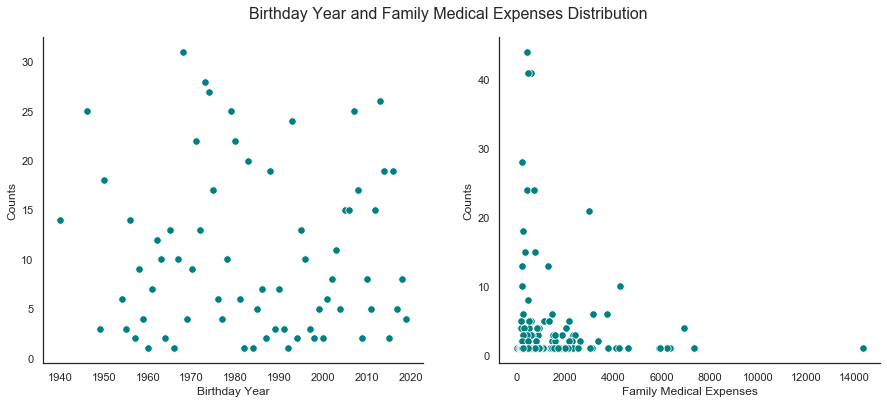

In [25]:
# Visualize the variables Birthday_year and Medical_Expenses_Family
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sev1 = sns.scatterplot(x=train_df['Birthday_year'].dropna().unique(), 
                      y=train_df.groupby('Birthday_year')['Family_Case_ID'].count(), color='teal', s=55, ax=axes[0])
sev1.set(xlabel='Birthday Year', ylabel='Counts')
sev1.grid(False)

sev2 = sns.scatterplot(
    x=tmp_df.Medical_Expenses_Family.dropna().unique(), 
    y=tmp_df.groupby('Medical_Expenses_Family')['Family_Case_ID'].count(), 
    color='teal', s=55, ax=axes[1])
sev2.set(xlabel='Family Medical Expenses', ylabel='Counts')
sev2.grid(False)
plt.suptitle("Birthday Year and Family Medical Expenses Distribution", y=0.95, fontsize=16)

sns.set(rc={'figure.figsize':(15, 5)}, style="whitegrid")
sns.despine(top=True, right=True, left=False, bottom=False)
sns.set_style("ticks")

In [26]:
counts = tmp_df[(tmp_df['Medical_Expenses_Family'] <= 5000)].groupby('Medical_Expenses_Family')['Family_Case_ID'].count()
counts[counts > 30]

Medical_Expenses_Family
217    41
221    44
225    44
364    41
Name: Family_Case_ID, dtype: int64

##### Takeaways
1. Birthday_year: Everything seems to be fine.
2. Medical_Expenses_Family: Once again we can realise the presence of an extreme outlier (14000 value).

## Coherence Checks
There doesn't seem anything wrong with the data in terms of coherency.

# Data Cleaning
In this section we will clean our data using a copy of our training data. After having decided on some preprocessing steps (e.g. missing value imputer, scalling) we will integrate them in the pipeline and tune their parameters with grid-search.

In [27]:
# Getting X_train and y_train
X_train, y_train = train_df.drop(columns='Deceased'), train_df.Deceased

# Getting copy of training data to use and define preprocessing steps
X_train_clean, y_train_clean = X_train.copy(), y_train.copy()

# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City"]  # low cardinality and categorical variables
metric_features = X_train.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list()  # metric variables

## Outliers

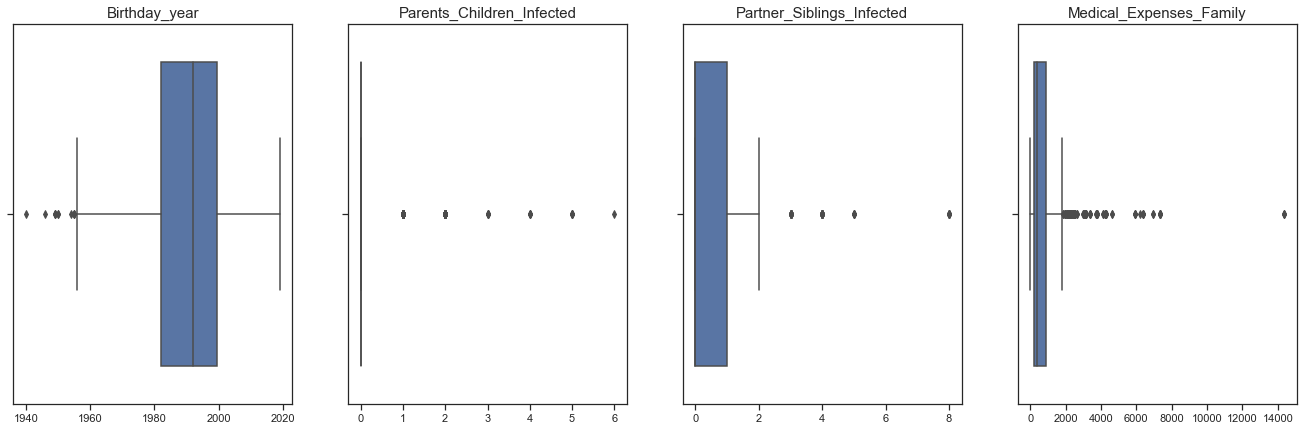

In [28]:
# 4 metric variables
fig = plt.figure(figsize=(23,7))
for i, var in enumerate(metric_features):
    i += 1
    plt.subplot(1,4,i)
    sns.boxplot(X_train_clean[var])
    plt.title(var, fontsize=15)
    plt.xlabel('')

In [29]:
# There are 3 observations with Medical_Expenses_Family above 8000 (all from the same family)
X_train_clean[(X_train_clean["Medical_Expenses_Family"] > 8000)]

,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
Patient_ID,,,,,,,,,
17,8608,1,Mr. Laurence Salvador,1984.0,1,0,14345,B,Albuquerque
301,8608,1,Mr. Norman Wayne,1985.0,0,0,14345,B,Albuquerque
621,8608,1,Ms. Geraldine Toni,1985.0,0,0,14345,NaN,Albuquerque


Although we believe these observations can be potential outliers, we will first normalize the variable by taking into acccount the family size as this may prove that these observations are not outliers at all (because large Medical Expenses can be justified by having a large family). So we will analyze the outliers for this variable after feature engineering.

## Missing Values
There are 3 variables that we have to treat regarding missing values. They are **Birthday_year, Medical_Tent and City**.

In [30]:
X_train_clean.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 702
City                           2
dtype: int64

In [31]:
# Checking missing values in test_df so that we can define imputation strategies for requiring columns. 
# In this case we don't need to worry with other columns besides the ones from the training data.
test_df.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                 82
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 311
City                           0
dtype: int64

#### City
There are only 2 null values in City so we decided to replace them with the mode, Santa Fe, that stands for the city of 72% of the patients.

In [32]:
X_train_clean.City.value_counts()

Santa Fe       649
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [33]:
# Imputing City variable
X_train_clean.City.fillna(value="Santa Fe", inplace=True)

#### Medical_Tent

78.06% of the observations have no value in Medical_Tent. The first thought is dropping the variable but on a second thought, the nulls in Medical_Tent may mean that they treated the disease at home. Or maybe the tent is just not known, we would have to ask the data owner to be sure, but for now we will replace the null values for 'NK' (Not Known) and then assess the variable discriminating power according to the target.

In [34]:
X_train_clean.Medical_Tent = X_train_clean.Medical_Tent.fillna(value="NK")
# test_df.Medical_Tent = test_df.Medical_Tent.fillna(value="NK")

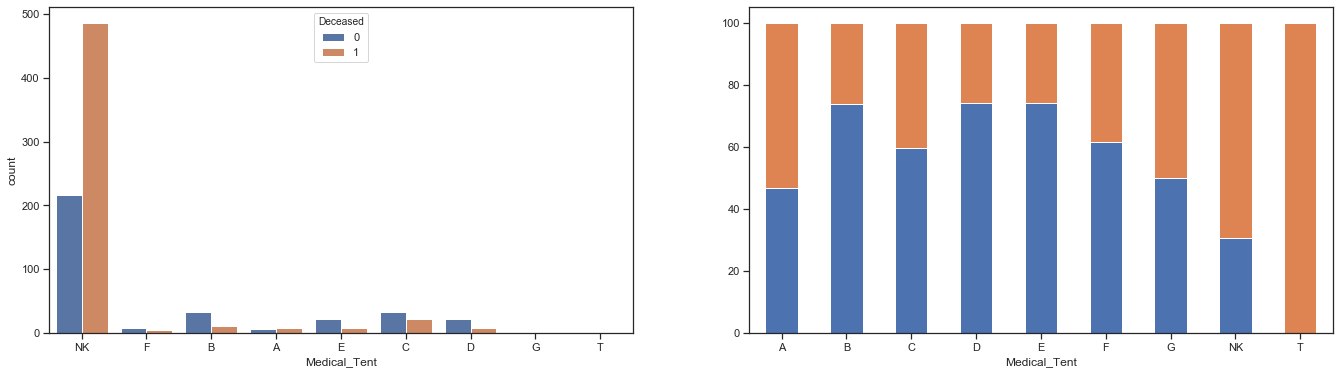

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 6))

sns.countplot(x="Medical_Tent", hue=y_train_clean, data=X_train_clean, ax=ax1)
c = pd.crosstab(X_train_clean['Medical_Tent'], y_train_clean).apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar', stacked=True, ax=ax2)  # linha magica da rita
ax2.get_legend().remove()

plt.xticks(rotation=0)
plt.show()

In [36]:
X_train_clean.Medical_Tent.value_counts()

NK    702
C      57
B      46
D      31
E      31
A      15
F      13
G       4
T       1
Name: Medical_Tent, dtype: int64

- The 'NK' (Not Known) class makes even clearer the low number of observations in other categories. This needs to be improved and we will join them to the newly class "K" (Known).
- It is also possible to see that the class "NK" has a higher deceased frequency whereas the other known classes have higher frequency of non-deceased. This suggests this variable can discriminate the target.

#### Birthday_year

In [37]:
X_train_clean.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                   0
City                           0
dtype: int64

We have 177 null values in the Birthday_year column. We consider this attribute gives us important information to predict the final outcome of the disease, so dropping the column is not an option and we have to think on the best way of imputting these values.<br>

Using a mean, median or mode doesn't make sense in this case, so we decided to use KNN imputter. When thinking on which attributes to use in the KNN, we concluded they shouldn't all be included. We believe Family_Case_ID, Name, City, Medical_Expenses_Family and Medical_Tent give us no information on the birthday year of a patient, on the other hand, knowing if the person has parents/children infected, partner/siblings infected and the severity of the desease can possibly help us in this task.<br><br>
After feature engineering, we realized that the variable Title was inherently related with Birthday_year. There's agreement between titles and ages except in two cases, Mister at 14, and Miss at 30s. As data preprocessing is an iterative process we decided to move the creation of this variable to this point, before imputing Birthday_year, as it offers information for imputing this attribute. 

In [38]:
# Creating title variable
X_train_clean['Title'] = X_train_clean['Name'].str.split('\\W', 1, expand=True)[0]
# test_df['Title'] = test_df['Name'].str.split('\\W', 1, expand=True)[0]

From the plots below we can conclude that Miss and Master are the ones that were born from 2003 on, while Mr and Mrs were born before that. Consequently, for the purpose of imputting Birthday_year, we should only maintain 2 categories merging Miss with Master and Mr with Mrs.

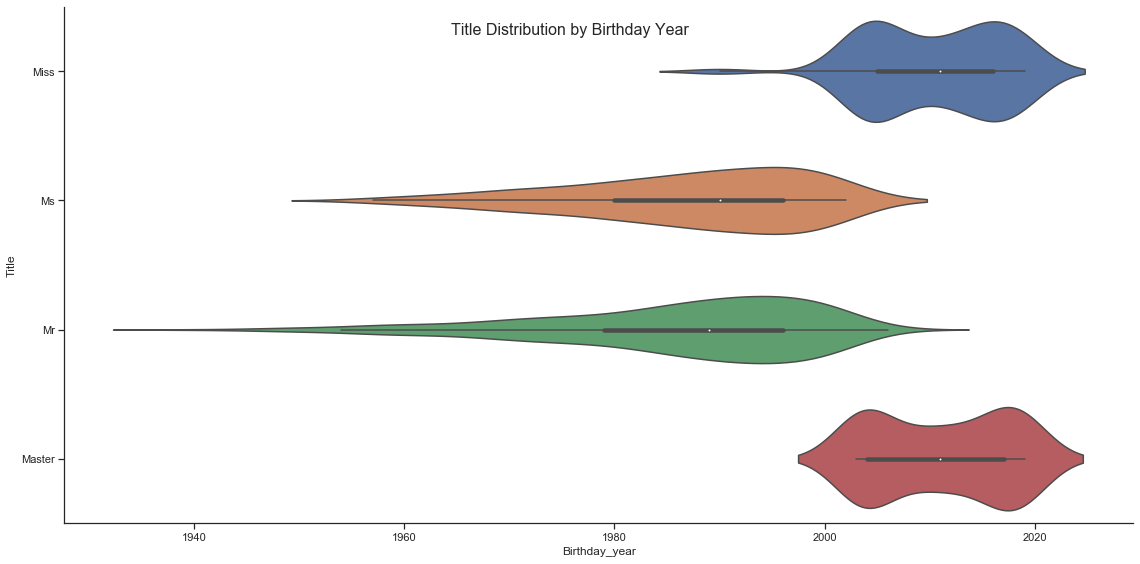

In [39]:
ax= sns.catplot(
    data=X_train_clean,
    y='Title',
    x='Birthday_year',
    kind='violin',
    height=8, aspect=2)
plt.suptitle("Title Distribution by Birthday Year", y=0.95, fontsize=16)
plt.show()

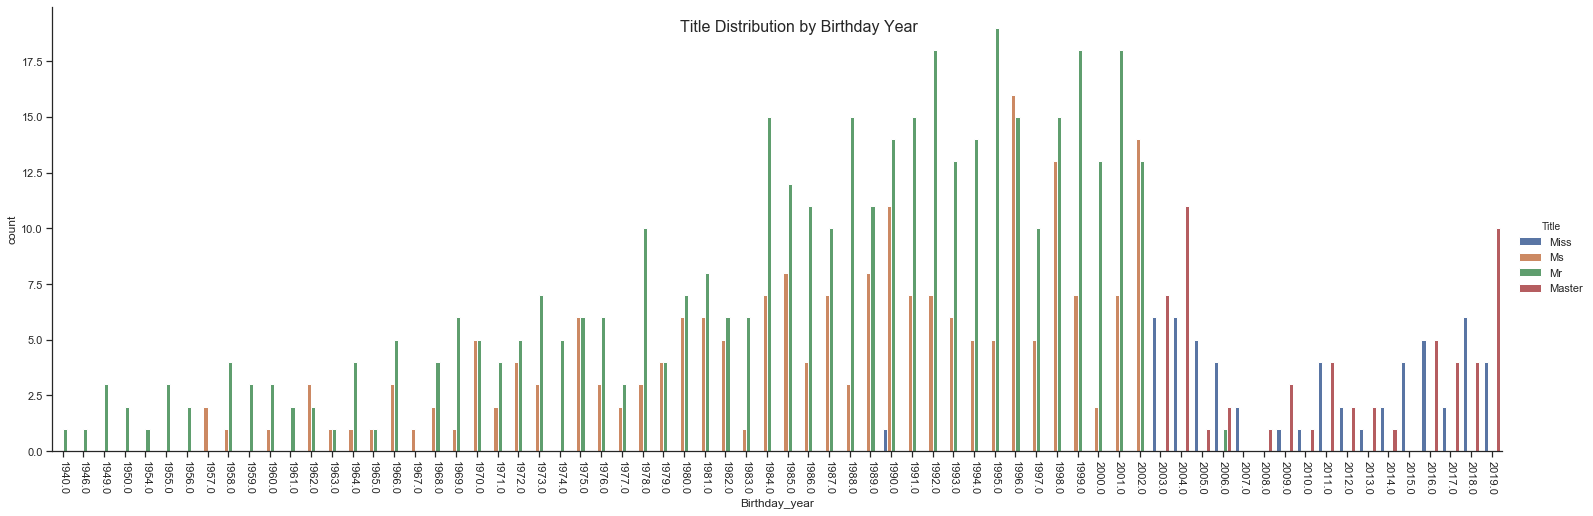

In [40]:
sns.catplot(x="Birthday_year", hue="Title",
               data=X_train_clean, kind="count",
               height=7, aspect=3)
plt.suptitle("Title Distribution by Birthday Year", y=0.95, fontsize=16)
plt.xticks(rotation=-90)
plt.show()

One other thing we realized when seing these plots was that we can only get Gender from the Title attribute. At first, we thought that we would be able to get Marital_status, but only in one case is the title used as a non-married female, but in many cases Ms is used without marital status implied. So we cannot assume marital status for all of the adults.

The Gender variable will be created in the Feature Engineering step.

In [41]:
# The nulls in Birthday_year are only Master and Miss, meaning people born in 2003 or later. This makes us think these are values missing not at random
X_train_clean[X_train_clean.Birthday_year.isnull()]["Title"].value_counts() 

Master    124
Miss       53
Name: Title, dtype: int64

In [42]:
# However we can see that in the test set Mr and Mrs are missing
test_df[test_df.Birthday_year.isnull()]['Name'].str.split('\\W', 1, expand=True)[0].value_counts()

Mr     58
Mrs    24
Name: 0, dtype: int64

In [43]:
# get the indexes of the rows with null values in the Birthday_year 
null_idx = list(X_train_clean[X_train_clean.Birthday_year.isnull()].index)
# null_idx_test = list(test_df[test_df.Birthday_year.isnull()].index)

In [44]:
# merging Miss with Master and Mr with Mrs
X_train_clean['Title_binary'] = X_train_clean['Title'].apply(lambda x: 1 if x in ["Master","Miss"] else 0)
# test_df['Title_binary'] = test_df['Title'].apply(lambda x: 1 if x in ["Master","Miss"] else 0)

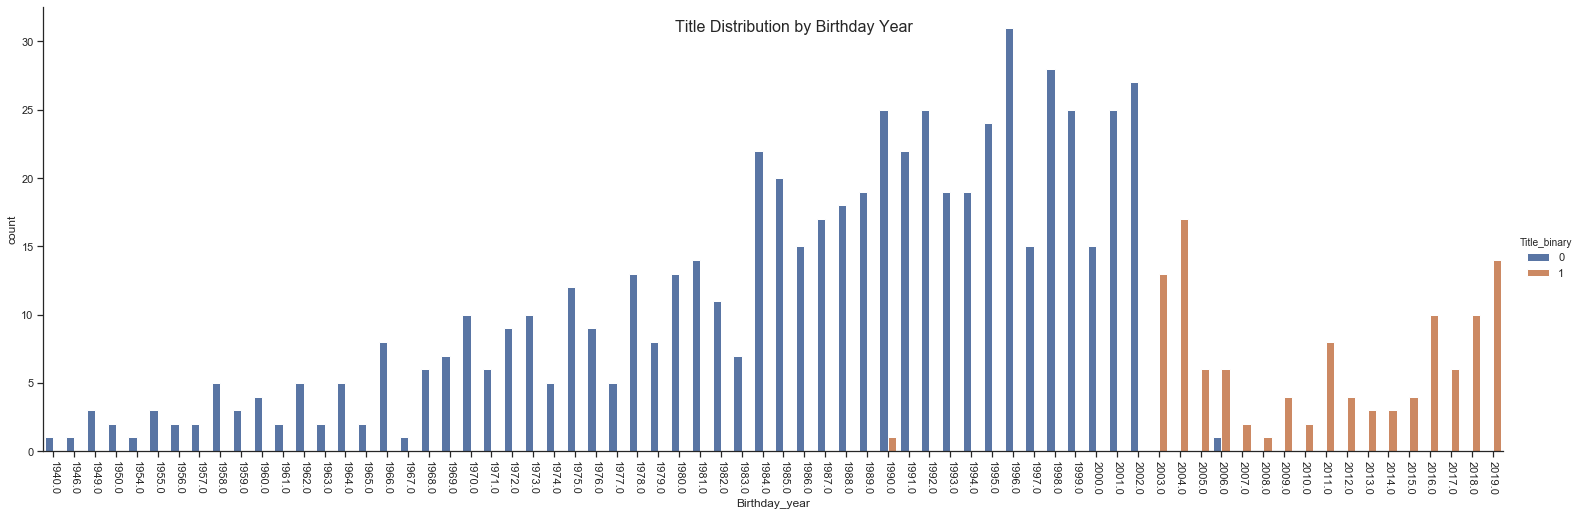

In [45]:
# get a clearer view of the title distribution 
sns.catplot(x="Birthday_year", hue="Title_binary",
               data=X_train_clean, kind="count",
               height=7, aspect=3)
plt.suptitle("Title Distribution by Birthday Year", y=0.95, fontsize=16)
plt.xticks(rotation=-90)
plt.show()

In [46]:
def scale_function(X_data, columns_to_norm, columns_not_norm, scaler_type, scaler=None):
    '''Function to apply normalization'''
    
    if scaler_type=='MinMaxScaler':
        if scaler is None:
            scaler = MinMaxScaler().fit(X_data[columns_to_norm])
        X_scaled = scaler.transform(X_data[columns_to_norm])
        
    else:
        if scaler is None:
            scaler = StandardScaler().fit(X_data[columns_to_norm])
        X_scaled = scaler.transform(X_data[columns_to_norm])
        
    X = np.append(X_data[columns_not_norm], X_scaled, axis=1)
    X = pd.DataFrame(X, columns = columns_not_norm+columns_to_norm)

    return X, scaler

In [47]:
scaler_type="MinMaxScaler"

In [48]:
def knn_imputer_birthday(X_train, test, scaler_type):
    cols_drop = ['Family_Case_ID','Name','Medical_Expenses_Family','Medical_Tent','City']
    columns_to_norm = ['Severity','Parents_Children_Infected','Partner_Siblings_Infected']
    columns_not_norm=['Birthday_year','Title_binary']
    
    X_use = X_train.copy()
    X_test = test.copy()
    
    fill_birthday_train, scaler = scale_function(X_use.drop(columns=cols_drop), columns_to_norm=columns_to_norm,
                                                 columns_not_norm=columns_not_norm, scaler_type=scaler_type)
#     fill_birthday_test, scaler = scale_function(X_test.drop(columns=cols_drop), columns_to_norm=columns_to_norm,
#                                                  columns_not_norm=columns_not_norm, scaler_type=scaler_type)
    
    imputer = KNNImputer(n_neighbors=3, weights='distance').fit(fill_birthday_train)
    
    X_imputted_birthday_train = imputer.transform(fill_birthday_train)
#     X_imputted_birthday_test = imputer.transform(fill_birthday_test)
    
    X_use.Birthday_year = list(pd.DataFrame(X_imputted_birthday_train).iloc[:,0]) # 0 is the index of Birthday_year
#     X_test.Birthday_year = list(pd.DataFrame(X_imputted_birthday_test).iloc[:,0]) # 0 is the index of Birthday_year
    
    return X_use, X_test

In [49]:
# impute missing values
# X_train, test_df = knn_imputer_birthday(X_train, test_df, scaler_type=scaler_type)
X_train_clean, _ = knn_imputer_birthday(X_train_clean, test_df, scaler_type=scaler_type)

In [50]:
# round Birthday_year
X_train_clean.Birthday_year = X_train_clean.Birthday_year.round(0).astype(int)
# test_df.Birthday_year = test_df.Birthday_year.round(0).astype(int)

In [51]:
# see where the distribution of the imputed values 
X_train_clean[X_train_clean.index.isin(null_idx)].Birthday_year.value_counts()

2005    99
2004    27
2003    17
2006    15
2013     7
2016     4
2012     3
2010     3
2019     2
Name: Birthday_year, dtype: int64

In [52]:
# see where the distribution of the imputed values 
# test_df[test_df.index.isin(null_idx_test)].Birthday_year.value_counts()

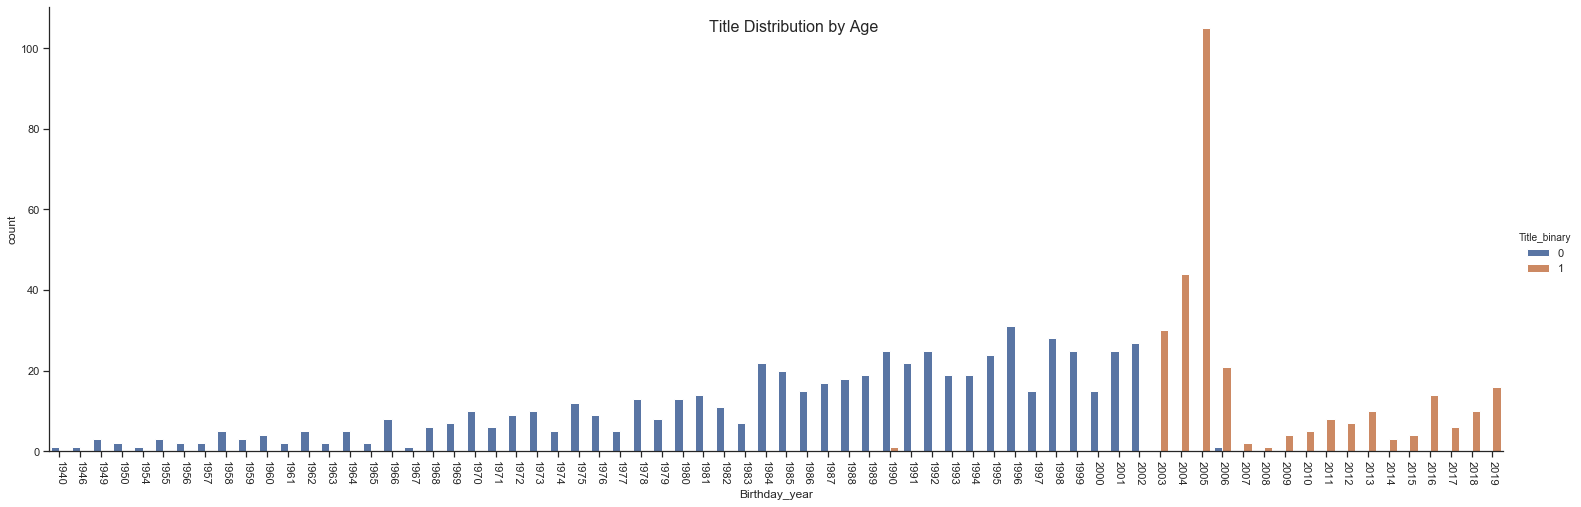

In [53]:
# Get a clearer view of the title distribution over Birthday_year
sns.catplot(x="Birthday_year", hue="Title_binary",
               data=X_train_clean, kind="count",
               height=7, aspect=3)
plt.suptitle("Title Distribution by Age", y=0.95, fontsize=16)
plt.xticks(rotation=-90)
plt.show()

In [54]:
X_train_clean.isnull().sum()

Family_Case_ID               0
Severity                     0
Name                         0
Birthday_year                0
Parents_Children_Infected    0
Partner_Siblings_Infected    0
Medical_Expenses_Family      0
Medical_Tent                 0
City                         0
Title                        0
Title_binary                 0
dtype: int64

In [55]:
# test_df.isnull().sum()

## Feature Engineering

In [56]:
def feature_engineering(X, types, y_train, dict_fam_size, familycount_test=None):
    # Age instead of Birth_year
    X["Age"] = X["Birthday_year"].map(lambda x: 2020 - x) 

    # Get gender based on Title
    X['Gender'] = X['Title'].map(lambda x: "Male" if x in ["Mr", "Master"] else "Female")  

    # Join classes with low cardinality (binary variables)
    X['Parents_Children_Infected_Binary'] = X['Parents_Children_Infected'].map(lambda x: 0 if x==0 else 1)  
    X['Partner_Siblings_Infected_Binary'] = X['Partner_Siblings_Infected'].map(lambda x: 0 if x==0 else 1)
    X["Medical_Tent_Binary"] = X["Medical_Tent"].map(lambda x: x if x == "NK" else "K")

    # If it's considered a pediatric case, may receive different attention
    X["Pediatric_Binary"] = X["Age"].map(lambda x: 1 if x < 18 else 0) 
    # If it's considered a third age case, may receive less care in case of medical overwhelming
    X["3rd_Age_Binary"] = X["Age"].map(lambda x: 1 if x >= 65 else 0) 

    # How many family members in record are infected (it counts with itself)
    if types == 'train':
        familycount = X.Family_Case_ID.value_counts().to_dict()
        X["Family_Infected"] = X["Family_Case_ID"].map(familycount) 
    else:
        X["Family_Infected"] = X["Family_Case_ID"].map(familycount_test).fillna(1)
        
    # If it has infected family members (doens't count itself)
    X["Family_Infected_Binary"] = X["Family_Infected"].map(lambda x: 0 if x==1 else 1)

    # How many other family members in record as deceased
    if types == 'train':
        X_train_w_dec = pd.concat([X, y_train], axis=1)
        deceasedfamcount = X_train_w_dec.loc[X_train_w_dec['Deceased']==1].Family_Case_ID.value_counts().to_dict()
        X["Family_Deceased"] = (X["Family_Case_ID"].map(deceasedfamcount)-1).fillna(0)
    else:
        X["Family_Deceased"] = (X["Family_Case_ID"].map(dict_fam_size)-1).fillna(0)
        
    X["Family_Deceased_Reduced"] = X['Family_Deceased'].map(lambda x: x if x==0 else (2 if x>=3 else 1))

    # Ratio of known deaths in the family
    X["Dead_infected_ratio_family"] = X["Family_Deceased"] / X["Family_Infected"]  

    # Normalize Medical_Expenses_Family by the family size
    X["Medical_Expenses_Individual"] = X["Medical_Expenses_Family"] / X["Family_Infected"]
    
    if types == 'train':
        return X, familycount, deceasedfamcount
    else:
        return X

In [57]:
X_train_clean, familycount, deceasedfamcount = feature_engineering(X=X_train_clean, types='train', y_train=y_train_clean, dict_fam_size=None)
# test_df = feature_engineering(X=test_df, types='test', y_train=None, dict_fam_size=deceasedfamcount, familycount_test=familycount)

In [58]:
# Possible incoherency: the number of elements in family 
((X_train_clean["Family_Infected"] - 1) - X_train_clean[["Parents_Children_Infected", "Partner_Siblings_Infected"]].sum(axis=1)).value_counts().sort_index()
# WHICH ONE TO USE? ASK TEATCHER

-6      1
-4      8
-3      8
-2     39
-1    131
 0    596
 1     73
 2     25
 3      9
 4      3
 6      7
dtype: int64

##### New Numerical Variables's Outliers Analysis

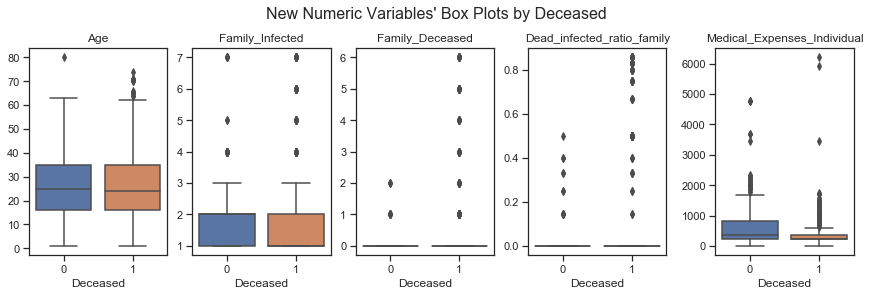

In [59]:
title = "New Numeric Variables' Box Plots by Deceased"
plot_features = ["Age", "Family_Infected", "Family_Deceased", "Dead_infected_ratio_family", "Medical_Expenses_Individual"]
plot_df = pd.concat([X_train_clean[plot_features], y_train_clean], axis=1)

box_plot_numerical(plot_df, plot_features, title)

In [60]:
(X_train_clean["Medical_Expenses_Individual"] > 3000).sum()  # 9 observations above 3000 in Medical_Expenses_Individual

9

- Medical_Expenses_Individual continues to have outliers and we decided to cap the values at 3000 as it will retain the observations with higher values and not bias the results. We will also drop the Medical_Expenses_Family variable as it isn't relativized.

In [61]:
# Cap variable at 3000
X_train_clean["Medical_Expenses_Individual"][X_train_clean["Medical_Expenses_Individual"] > 3000] = 3000
# test_df["Medical_Expenses_Individual"][test_df["Medical_Expenses_Individual"] > 3000] = 3000

# Drop Medical_Expenses_Family
X_train_clean.drop("Medical_Expenses_Family", axis=1, inplace=True)
# test_df.drop("Medical_Expenses_Family", axis=1, inplace=True)

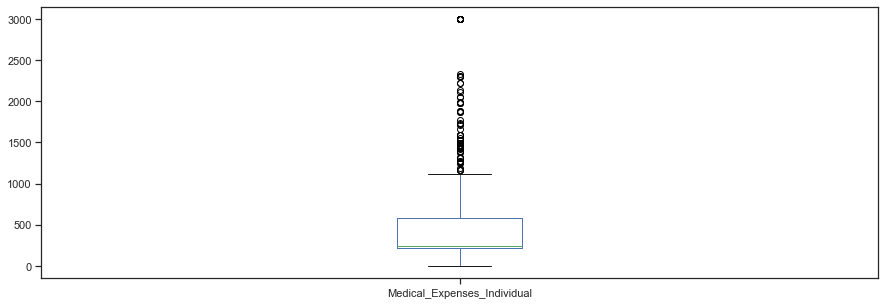

In [62]:
X_train_clean["Medical_Expenses_Individual"].plot(kind="box")
plt.show()

##### New Categorical Variables's Insights

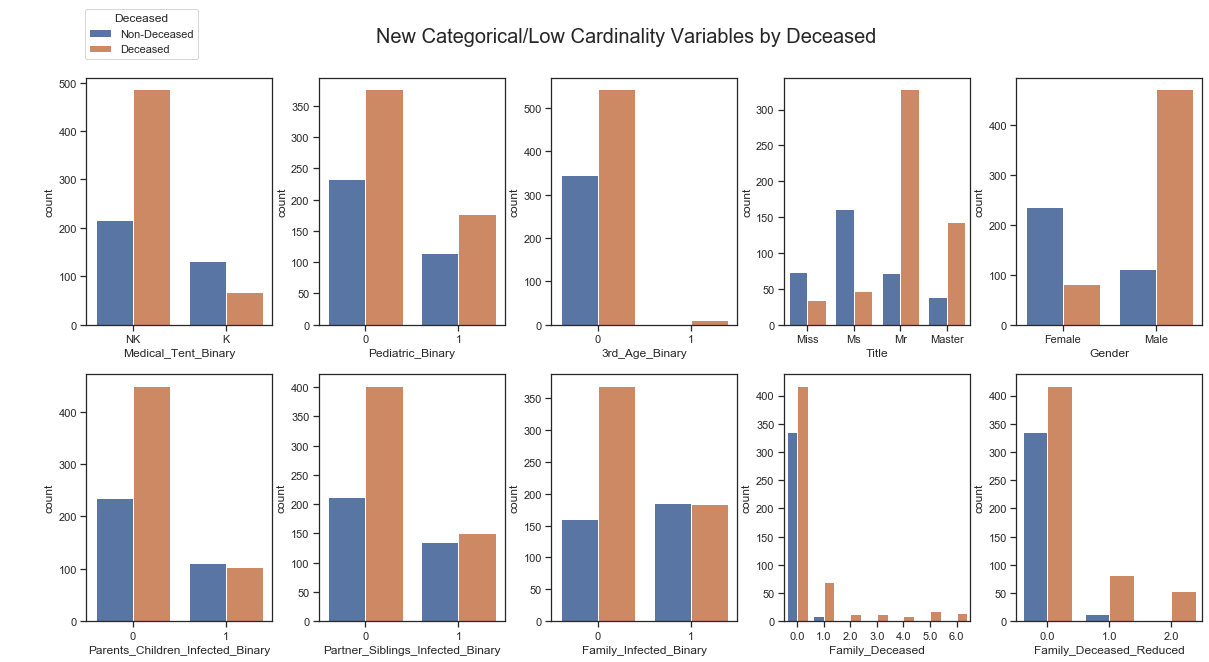

In [63]:
title = "New Categorical/Low Cardinality Variables by Deceased"
# data to plot
plot_features = ["Medical_Tent_Binary", "Pediatric_Binary", "3rd_Age_Binary", "Title", "Gender", 
                 "Parents_Children_Infected_Binary", "Partner_Siblings_Infected_Binary", "Family_Infected_Binary",
                 "Family_Deceased", "Family_Deceased_Reduced"]
plot_df = pd.concat([X_train_clean[plot_features], y_train_clean], axis=1)

categorical_cardinality_plot(plot_df, plot_features, title)

In [64]:
y_train_clean.loc[X_train_clean["Family_Deceased"] > 2].value_counts()  # All patients with Family_Deceased above 2 died

1    54
Name: Deceased, dtype: int64

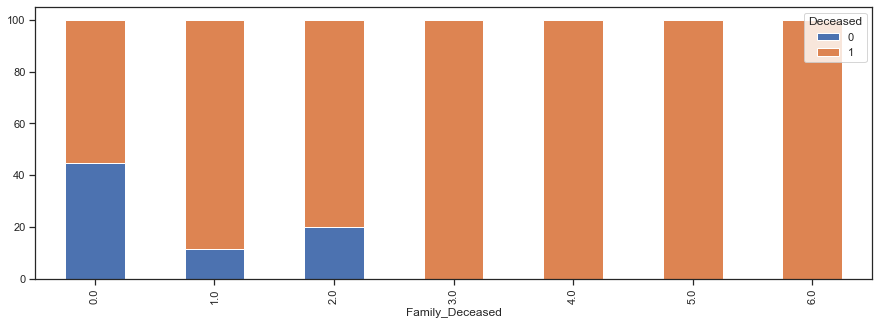

In [65]:
pd.crosstab(X_train_clean['Family_Deceased'], y_train_clean).apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar', stacked=True)
plt.show()

- Medical_Tent_Binary has a good discriminant power
- Pediatric_Binary and 3rd_Age_Binary have no relevant discriminancy and low frequency of value 1, respectively
- Title gives the same information of Gender but has more classes, so it should be dropped
- Gender has a good discriminant power
- Partner_Siblings_Infected_Binary and Parents_Children_Infected_Binary are very similar in terms of the information provided. Family_Infected_Binary was created in order to account for the information provided by these two
- Family_Deceased appears to present some discrimancy power, however it can benefit from having its cardinality reduced as for values above 2 the proportion of Deceased is 1.

We will drop the following variables below: Pediatric_Binary, 3rd_Age_Binary, Title, Partner_Siblings_Infected_Binary, Parents_Children_Infected_Binary, Family_Deceased.

##### Dead_infected_ratio_family

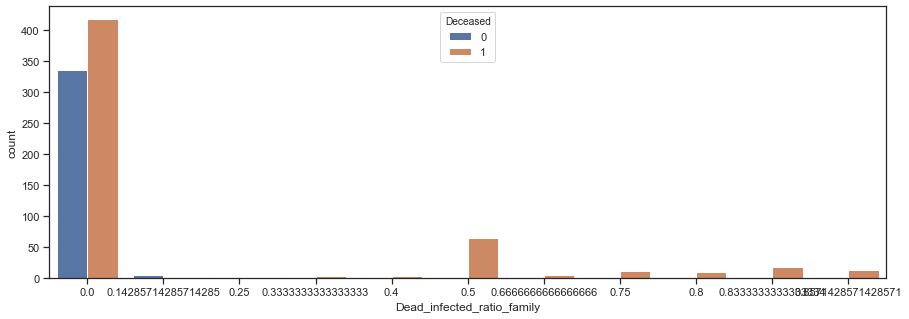

In [66]:
sns.countplot(x="Dead_infected_ratio_family", hue=y_train_clean, data=X_train_clean)
plt.show()

We believe this variable is similar to Family_Deceased, however we will check the correlations before making any assumption.

##### Medical_Expenses_Individual - distribution centering

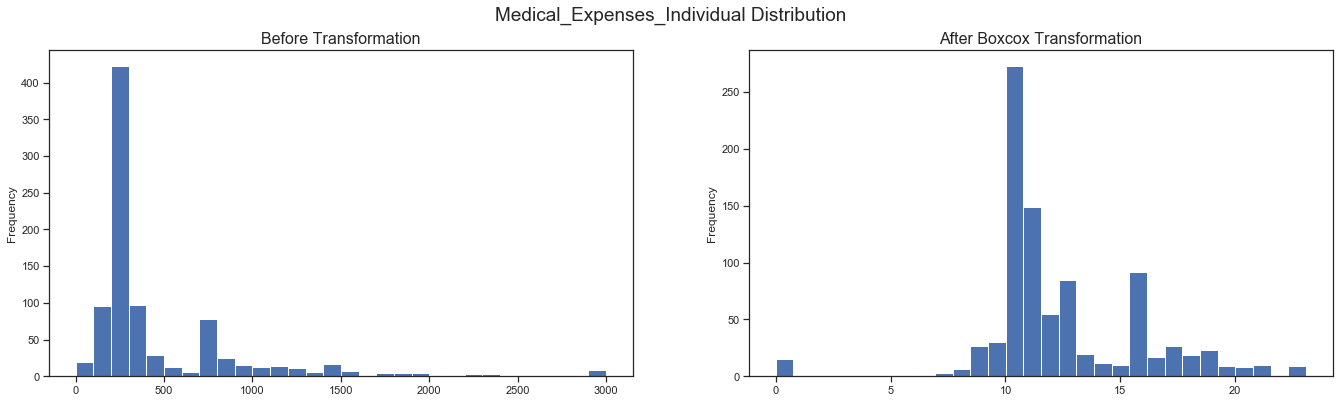

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(23, 6))

# BoxCox transformation to center the distribution of Medical_Expenses_Individual
before = pd.Series(X_train_clean["Medical_Expenses_Individual"]).plot(kind="hist", bins=30, ax=ax1)
after = pd.Series(boxcox(X_train_clean["Medical_Expenses_Individual"] + 1)[0]).plot(kind="hist", bins=30, ax=ax2)
before.set_title('Before Transformation', fontsize=16)
after.set_title('After Boxcox Transformation', fontsize=16)

plt.suptitle('Medical_Expenses_Individual Distribution', fontsize=19)
plt.xticks(rotation=0)
plt.show()

We will apply a boxcox transformation to center the distribution of Medical_Expenses_Individual. This will turn out beneficial when applying some of the models.

In [68]:
alph = boxcox(X_train_clean["Medical_Expenses_Individual"] + 1)[1]
X_train_clean["Medical_Expenses_Individual"] = boxcox(X_train_clean["Medical_Expenses_Individual"] + 1, alpha=alph)[0]
# test_df["Medical_Expenses_Individual"] = boxcox(test_df["Medical_Expenses_Individual"] + 1, alpha=alph)[0]

In [69]:
# Drop useless variables
X_train_clean.drop(["Family_Case_ID", "Pediatric_Binary", "Name", "Birthday_year", "3rd_Age_Binary", "Title", "Title_binary", "Partner_Siblings_Infected", "Medical_Tent", 
                    "Parents_Children_Infected", "Partner_Siblings_Infected_Binary", "Parents_Children_Infected_Binary", "Family_Deceased", "Family_Infected",], axis=1, inplace=True)
# test_df.drop(["Family_Case_ID", "Pediatric_Binary", "Name", "Birthday_year", "3rd_Age_Binary", "Title", "Title_binary", "Partner_Siblings_Infected", "Medical_Tent", 
#               "Parents_Children_Infected", "Partner_Siblings_Infected_Binary", "Parents_Children_Infected_Binary", "Family_Deceased", "Family_Infected",], axis=1, inplace=True)

## Correlations
Assess preprocessed data using correlation plot. Check redudant variables and do some feature selection.

In [70]:
X_train_clean.head() # everything seems okay!

,Severity,City,Age,Gender,Medical_Tent_Binary,Family_Infected_Binary,Family_Deceased_Reduced,Dead_infected_ratio_family,Medical_Expenses_Individual
Patient_ID,,,,,,,,,
1,3,Santa Fe,15,Female,NK,0,0.0,0.0,10.782511
2,1,Albuquerque,54,Female,NK,0,0.0,0.0,19.604952
3,3,Santa Fe,38,Male,NK,0,0.0,0.0,10.720469
4,3,Santa Fe,23,Male,NK,0,0.0,0.0,10.704824
5,3,Santa Fe,26,Female,NK,0,0.0,0.0,10.736060


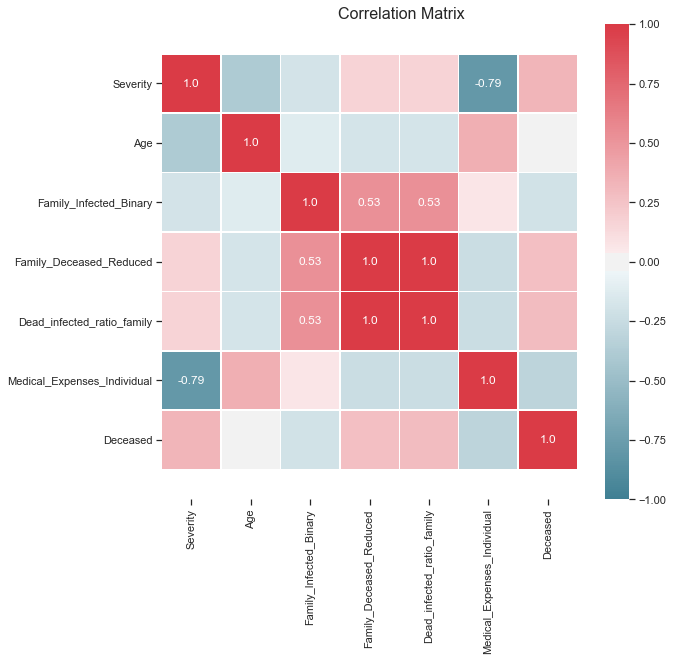

In [71]:
def cor_heatmap(cor):
    plt.figure(figsize=(10, 8))
    
    cor = round(cor,2)
    
    mask_annot = np.absolute(cor.values)>=0.5
    annot1 = np.where(mask_annot, cor.values, np.full(cor.shape,""))
    sns.heatmap(data=cor, annot=annot1, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='s', vmin=-1, vmax=1,
               center=0, square=True, linewidths=.5)
    
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation Matrix", fontsize=16)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

corr = pd.concat([X_train_clean, y_train_clean], axis=1).corr(method="spearman")
cor_heatmap(corr)

The variables Dead_infected_ratio_family and Family_Deceased_Reduced are perfectly correlated as expected so we should drop one of them because they will give the exact same information to the model. We decided to keep Family_Deceased_Reduced because it provides a cleaner interpretation. 

In [72]:
X_train_clean.drop("Dead_infected_ratio_family", axis=1, inplace=True)
# test_df.drop("Dead_infected_ratio_family", axis=1, inplace=True)

In [73]:
X_train_clean.head()

,Severity,City,Age,Gender,Medical_Tent_Binary,Family_Infected_Binary,Family_Deceased_Reduced,Medical_Expenses_Individual
Patient_ID,,,,,,,,
1,3,Santa Fe,15,Female,NK,0,0.0,10.782511
2,1,Albuquerque,54,Female,NK,0,0.0,19.604952
3,3,Santa Fe,38,Male,NK,0,0.0,10.720469
4,3,Santa Fe,23,Male,NK,0,0.0,10.704824
5,3,Santa Fe,26,Female,NK,0,0.0,10.736060


In [74]:
# test_df.head()

# Modelling
In this section we will build our custom sklearn Pipeline and use it to find out the best hyperparameters according to the model accuracy. We will also use it to select the most appropriate classifier algorithm and do model comparision.
### Why Pipelines? 

- **Convenience and encapsulation**:

We only had to call fit once on our data to fit a whole sequence of estimators (i.e. from missing values imputation to model algorithm). By calling predict this whole sequence was applied on new observations.

- **Joint parameter selection**:

We can grid search over parameters of all estimators in the pipeline at once. By finding the optimal hyperparameters independently we are not guaranteed to find the optimal hyperparameter combination.

- **Safety**:

Pipelines help avoid leaking statistics from our test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors. The whole pipeline is fitted in each iteration of cross-validation, if we fitted it prior to cross-validation then we would always have an already "seen" test fold and the model selection process could be compromised by biased accuracy estimates.

- **Easy Deployment and Maintenance**:

Pipelines can be fully deployed which means that we only have to use predict on new test data without the need to train our pipeline every time. Furthermore, maintenance is facilitaded as we can access the steps of the pipeline and know exactly which sequence is used to transform the data. Also this is a way to standardize code and model building.


___
We are aware that this isn't the standard approach, however we were interested in understanding how a Machine Learning model can be deployed in production and in providing the most unbiased model selection process.

In [75]:
# Ensuring data is ready to be passed to pipeline (i.e. it hasn't been touched):
X_train.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
Patient_ID,,,,,,,,,
1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe
2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque
3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe
4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe
5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe


In [76]:
X_train.shape

(900, 9)

In [77]:
X_train.isna().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 702
City                           2
dtype: int64

In [78]:
test_df.head()

,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
Patient_ID,,,,,,,,,
901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


In [79]:
test_df.shape

(400, 9)

In [80]:
test_df.isna().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                 82
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 311
City                           0
dtype: int64

- Data seems to be ready to be passed to pipeline (i.e. raw state).

In [81]:
# AUXILIAR FUNCTIONS

# Saving parameter grid for specific Grid Search run
class ComplexEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (StandardScaler, MinMaxScaler, OneHotEncoder, ExtraTreesClassifier, RandomForestClassifier, KNeighborsClassifier, NeighborhoodComponentsAnalysis, LogisticRegression, SelectFromModel, np.ndarray, dict)):  # Include all classes that aren't serializable here
            return str(obj)
        # Let the base class default method raise the TypeError 
        return json.JSONEncoder.default(self, obj)
    

def gs_outputs(id_num, gscv_fitted, grid):
    """
    Function that saves information of each grid-search.
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    grid: takes the grid used to fit the GridSearchCV object
    
    Returns:
    top 20 configurations hyper-parameter presence graphic
    (also outputs the "logs" of each grid-search to the output directory)
    """
    # Saving parameter grid for specific Grid Search run
    with open("./outputs/grids.txt", "a") as file:
        file.write("# {}------------------------------------------------------ #\n".format(id_num) + json.dumps(grid, cls=ComplexEncoder) + "\n\n")

    # Saving cv_results for specific Grid Search run
    score_summary = pd.DataFrame(gscv_fitted.cv_results_).sort_values(by="mean_test_score", ascending=False)
    score_summary.to_csv("./outputs/grid_search_results{}.csv".format(id_num))
    
    # Assessing distribution of hyper-parameter values amongst top 20 models
    sns.set()

    # Features to plot
    plot_features = list(map(lambda x: "param_" + x, {i for j in range(len(grid)) for i in grid[j].keys()}))
    plot_df = score_summary.reset_index(drop=True).loc[:19, :].fillna("NaN")

    # figure and axes
    fig, axes = plt.subplots(3, ceil(len(plot_features)/3), figsize=(23,13))

    # plot data
    for ax, x in zip(axes.flatten(), plot_features):
        try:
            sns.countplot(x=x, data=plot_df, ax=ax)
        except TypeError:
            sns.countplot(x=plot_df[x].apply(json.dumps), ax=ax)

    plt.suptitle("Hyper-parameter presence on top 20 models", y=0.95, fontsize=25)

    plt.savefig("./outputs/grid_results{}.png".format(id_num))
    
    # Model training - using best parameters to train model on entire data for submission
    best_model = full_pipeline.set_params(**gscv_fitted.best_params_)
    best_model.fit(X_train, y_train)  # Using all of the data to fit the model

    # Predicting the 
    y_pred = best_model.predict(test_df)

    # Submission
    pd.DataFrame(data={"Patient_ID": test_df.index.to_list(), "Deceased": y_pred}).to_csv("./outputs/submission{}.csv".format(id_num), index=False)
    
    return plt.show()


def feature_importance(id_num, gscv_fitted, fimp_pre=True):
    """
    Function that show feature importance plot and saves it to outputs folder
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    fimp_pre: whether to evaluate feature importance pre or pos model
    
    Returns:
    feature importance graphic    
    """
    if fimp_pre:
        if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"] != 'passthrough'):

            # Get feature names
            numeric_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[0][2]
            categorical_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[1][2]
            categorical_features = list(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].named_transformers_["ohe"].get_feature_names(categorical_features))
            feature_names = numeric_features + categorical_features

            # Get feature importances
            if hasattr(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_, "feature_importances_"):  # Check if features_importances_ attribute exists. Necessary when there's tree selectors
                if len(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_.shape) != 2: 
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_, index=feature_names).T
                else:
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.feature_importances_, index=gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.classes_, columns=feature_names)
            else:
                if len(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_.shape) != 2: 
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_, index=feature_names).T
                else:
                    feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.coef_, index=gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].estimator_.classes_, columns=feature_names)

            colors = feature_importances.applymap(lambda x: "tab:red" if x < 0 else "tab:blue")  # Get positive and negative colors
            threshold = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].threshold_  # Get SelectFromModel threshold value 

            sns.set()
            if feature_importances.shape[0] == 3:
                fig, axes = plt.subplots(3, 1, figsize=(23,12))
                blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
                red_patch = mpatches.Patch(color='tab:red', label='Negative')
                threshold_line = mlines.Line2D([], [], linestyle="dashed", color='black', label='Threshold')

                for i, ax in enumerate(axes.flatten()):
                    ax.bar(x=feature_names, height=abs(feature_importances.iloc[i]), color=colors.iloc[i])
                    ax.hlines(threshold, -0.5, 18.5, linestyles="dashed")
                    ax.set_xticklabels(feature_names, rotation = 30, ha="right")
                    ax.set_title("Class {} Feature Importance".format(feature_importances.index[i]), fontsize=18)
                    ax.legend(handles=[blue_patch, red_patch, threshold_line], fontsize=12)

                plt.subplots_adjust(hspace=0.6)
                plt.savefig("./outputs/feature_importance{}.png".format(id_num))
                return plt.show()
            else: 
                fig = plt.figure(figsize=(23,6))
                blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
                red_patch = mpatches.Patch(color='tab:red', label='Negative')
                threshold_line = mlines.Line2D([], [], linestyle="dashed", color='black', label='Threshold')

                plt.bar(x=feature_names, height=abs(feature_importances.iloc[0]), color=colors.iloc[0])
                plt.hlines(threshold, -0.5, len(feature_names) - 0.5, linestyles="dashed")
                plt.xticks(rotation=30, ha="right")
                plt.title("Pre Feature Importance", fontsize=18)
                plt.legend(handles=[blue_patch, red_patch, threshold_line], fontsize=12)

                plt.savefig("./outputs/feature_importance_pre{}.png".format(id_num))
                return plt.show()
        else:
            print("No feature selection was done!")
    else:
        if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["dimred"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["dimred"] != 'passthrough'):
            # Obtaining Component Names
            feature_names = ["PC" + str(i) for i in range(1, best_model.named_steps["prep"].named_steps["dimred"].n_components + 1)]
        else:  
            # Get feature names
            numeric_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[0][2]
            categorical_features = gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].transformers_[1][2]
            categorical_features = list(gscv_fitted.best_estimator_.named_steps["prep"].named_steps["join"].named_transformers_["ohe"].get_feature_names(categorical_features))
            feature_names = numeric_features + categorical_features

            # Get filtered feature names
            if (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"]) and (gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"] != 'passthrough'):
                feature_names = np.array(feature_names)[gscv_fitted.best_estimator_.named_steps["prep"].named_steps["fselect"].get_support()]

        # Get feature importances
        if len(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_.shape) != 2: 
            feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_, index=feature_names).T
        else:
            feature_importances = pd.DataFrame(gscv_fitted.best_estimator_.named_steps["model"].feature_importances_, index=gscv_fitted.best_estimator_.named_steps["model"].classes_, columns=feature_names)
        
        colors = feature_importances.applymap(lambda x: "tab:red" if x < 0 else "tab:blue")  # Get positive and negative colors

        sns.set()
        fig = plt.figure(figsize=(23,6))
        blue_patch = mpatches.Patch(color='tab:blue', label='Positive')
        red_patch = mpatches.Patch(color='tab:red', label='Negative')

        plt.bar(x=feature_names, height=abs(feature_importances.iloc[0]), color=colors.iloc[0])
        plt.xticks(rotation=30, ha="right")
        plt.title("Pos Feature Importance", fontsize=18)
        plt.legend(handles=[blue_patch, red_patch], fontsize=12)

        plt.savefig("./outputs/feature_importance_pos{}.png".format(id_num))
        return plt.show()

In [82]:
# CUSTOM TRANSFORMERS BUILT FOR PIPELINE

class PrepImpute(BaseEstimator, TransformerMixin):
    """
    Creates Title
    Creates Title_binary
    Fills Medical_Tent with "NK"
    Imputes City with most frequent value
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        self.city_imputer = SimpleImputer(strategy="most_frequent")
        
    #Return self nothing else to do here
    def fit(self, X, y=None):
        self.city_imputer.fit(X[["City"]])
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X):
        
        X2 = X.copy()
        
        # CREATE NEW VARIABLES
        X2['Title'] = X2['Name'].str.split('\\W', 1, expand=True)[0]
        X2['Title_binary'] = X2['Title'].apply(lambda x: 1 if x in ["Master","Miss"] else 0)
        X2["Medical_Tent"] = X2["Medical_Tent"].fillna(value="NK")
        X2['City'] = self.city_imputer.transform(X2[["City"]])
        
        return X2 
    

class KNNImputerScaled(KNNImputer):
    """
    KNNImputer subclass that scales variables before applying imputation
    Impute Birthday_year using scaled and non-scaled variables with KNNImputer
    """
    def __init__(self, missing_values=np.nan, n_neighbors=5, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,
                 columns_to_norm=['Severity','Parents_Children_Infected','Partner_Siblings_Infected'], columns_not_to_norm=['Birthday_year','Title_binary'],
                 scaler=MinMaxScaler(), **scaler_args):
        super().__init__(missing_values=missing_values, 
                         n_neighbors=n_neighbors, 
                         weights=weights,
                         metric=metric,
                         copy=copy, 
                         add_indicator=add_indicator)
        self.scaler = scaler.set_params(**scaler_args)
        self.columns_to_norm = columns_to_norm
        self.columns_not_to_norm = columns_not_to_norm
        
    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X[self.columns_to_norm])
        X_trans = np.concatenate([X_scaled, X[self.columns_not_to_norm]], axis=1)
        super().fit(X_trans)
        return self
    
    def transform(self, X, y=None):
        X_scaled = self.scaler.transform(X[self.columns_to_norm])
        X_trans = np.concatenate([X_scaled, X[self.columns_not_to_norm]], axis=1)
        X_imputed_scaled = pd.DataFrame(super().transform(X_trans), index=X.index, columns=self.columns_to_norm + self.columns_not_to_norm)
        X_imputed = X.copy()
        X_imputed["Birthday_year"] = X_imputed_scaled["Birthday_year"].round(0).astype(int)
        
        return X_imputed
    
    
class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    Creates Age
    Creates Gender
    Ceates Parents_Children_Infected_Binary
    Creates Partner_Siblings_Infected_Binary
    Creates Medical_Tent_Binary
    Creates Family_Infected
    Creates Family_Infected_Binary
    Creates Family_Deceased
    Creates Family_Deceased_Reduced
    Creates Medical_Expenses_Individual
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass    
        
    #Return self nothing else to do here
    def fit(self, X, y):
        self.familycount_ = X.Family_Case_ID.value_counts().to_dict()
        X_train_w_dec = pd.concat([X, y], axis=1)
        self.deceasedfamcount_ = X_train_w_dec.loc[X_train_w_dec['Deceased']==1].Family_Case_ID.value_counts().to_dict()
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X):
        X2 = X.copy()
        # CREATE NEW VARIABLES
        X2['Age'] = X2['Birthday_year'].map(lambda x: 2020 - x)
        X2['Gender'] = X2['Title'].map(lambda x: "Male" if x in ["Mr", "Master"] else "Female")
        X2['Parents_Children_Infected_Binary'] = X2['Parents_Children_Infected'].map(lambda x: 0 if x==0 else 1)  
        X2['Partner_Siblings_Infected_Binary'] = X2['Partner_Siblings_Infected'].map(lambda x: 0 if x==0 else 1)
        X2["Medical_Tent_Binary"] = X2["Medical_Tent"].map(lambda x: x if x == "NK" else "K")
        #X2["Pediatric_Binary"] = X2["Age"].map(lambda x: 1 if x < 18 else 0)
        #X2["3rd_Age_Binary"] = X2["Age"].map(lambda x: 1 if x >= 65 else 0)
        X2["Family_Infected"] = X2["Family_Case_ID"].map(self.familycount_).fillna(1)
        X2["Family_Infected_Binary"] = X2["Family_Infected"].map(lambda x: 0 if x<=1 else 1)
        X2["Family_Deceased"] = (X2["Family_Case_ID"].map(self.deceasedfamcount_) - 1).fillna(0)
        X2["Family_Deceased_Reduced"] = X2['Family_Deceased'].map(lambda x: x if x==0 else (2 if x>=3 else 1))
        #X2["Dead_infected_ratio_family"] = X2["Family_Deceased"] / X2["Family_Infected"]
        X2["Medical_Expenses_Individual"] = X2["Medical_Expenses_Family"] / X2["Family_Infected"]
        # FURTHER TRANSFORMATIONS
        X2["Medical_Expenses_Individual"][X2["Medical_Expenses_Individual"] > 3000] = 3000
        
        return X2 
    
    
class Transformations(BaseEstimator, TransformerMixin):
    """
    Transforms Medical_Expenses_Individual by applying Box-Cox power transformation
    Drops unnecessary variables
    """
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass
    
    
    def get_alpha(self):
        return self.alpha_
        
    #Return self nothing else to do here
    def fit(self, X, y=None):
        self.alpha_ = boxcox(X["Medical_Expenses_Individual"] + 1)[1]
        return self

    #Transformer method we wrote for this transformer 
    def transform(self, X):
        X2 = X.copy()
        X2["Medical_Expenses_Individual"] = boxcox(X2["Medical_Expenses_Individual"] + 1, alpha=self.alpha_)[0]
        # DROP INTERMEDIATE VARIABLES
        X2 = X2.drop(["Family_Case_ID", "Name", "Birthday_year", "Title", "Title_binary", "Partner_Siblings_Infected", 
                    "Medical_Tent", "Parents_Children_Infected", "Partner_Siblings_Infected_Binary", 
                    "Parents_Children_Infected_Binary", "Family_Deceased", "Family_Infected", "Medical_Expenses_Family"], axis=1)
        
        return X2 

In [84]:
# Data Cleaning Pipeline
clean_pipeline = Pipeline([
    ('prepimpute', PrepImpute()),
    ('knnimputer', KNNImputerScaled()),  # tune: n_neighbors, weights, scaler
    ('engineering', FeatureEngineering()),
    ('transformation', Transformations())
])

# Spliting features
scale_columns = ["Severity", "Age", "Family_Deceased_Reduced", "Medical_Expenses_Individual"]
ohe_columns = ["City", "Gender", "Medical_Tent_Binary", "Family_Infected_Binary"]

# Combining features and applying different transformations
join_pipeline = ColumnTransformer([('scaler', "passthrough", scale_columns),
                                   ('ohe', OneHotEncoder(sparse=False), ohe_columns)])  # tune: drop

# Feature Selection - SelectKBest, ExtraTreesRegressor, Elasticnet
fselect1 = SelectFromModel(LogisticRegression(penalty="elasticnet", max_iter=400, solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C, l1_ratio=0 (l2) l1_ratio=1 (l1)
fselect2 = SelectFromModel(ExtraTreesClassifier(n_estimators=20, n_jobs=-1, random_state=1))
fselect3 = SelectKBest()  # tune: k

# Dimensionality Reduction - NeighborhoodComponentsAnalysis, PCA
dimred1 = NeighborhoodComponentsAnalysis(max_iter=25, tol=0.005, random_state=1)  # tune: n_components, tol=0.005 (it takes to long)
dimred2 = PCA(random_state=1)

# Full Preprocessing Pipeline
prep_pipeline = Pipeline([
    ("clean", clean_pipeline),
    ("join", join_pipeline),
    ("fselect", "passthrough"),
    ("dimred", "passthrough")
])

# Models - Decision Trees, Random Forests, XG Boost, MLP, KNN, Logistic Regression (Stackings, Bagging, Keras NN)
lr = LogisticRegression(max_iter=400, random_state=1, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=1, n_jobs=-1)
mlp = MLPClassifier()
et = ExtraTreesClassifier(random_state=1, n_jobs=-1)
svm = SVC(random_state=1)
adab = AdaBoostClassifier(random_state=1)
stacking = StackingClassifier(estimators=[('svm', svm), ('rf', rf), ('knn', knn)], final_estimator=lr, n_jobs=-1)
# xgb =  # XG Boost

# Full Model Pipeline
full_pipeline = Pipeline([
    ("prep", prep_pipeline),
    ("model", "passthrough")
])

grid = [
    {"prep__clean__knnimputer__n_neighbors": [5, 15],
     "prep__clean__knnimputer__weights": ["distance"],
     "prep__clean__knnimputer__scaler": [MinMaxScaler()],
     "prep__join__scaler": [None, MinMaxScaler()],
     "prep__join__ohe__drop": [None, "first"],
     "prep__fselect": [None, fselect2],
     "prep__dimred": [None],
     "model": [rf, et],
     "model__bootstrap": [True, False],
     "model__n_estimators": [150, 200],
     "model__criterion": ['gini', 'entropy'],
     "model__max_depth": [None, 10, 20],
     "model__max_features": ["sqrt", 0.5],
     "model__ccp_alpha": [0, 0.015, 0.02, 0.025],
     "model__max_samples": [None, 0.5]
    }
]

In [85]:
# # Instatiating GridSearch
# gscv = GridSearchCV(full_pipeline, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), scoring='accuracy', return_train_score=True, verbose=1, n_jobs=-1)

# # Get ID of grid search
# id_num = input("Insert GridSearch ID number: ")

# # Grid Search and model training
# gscv.fit(X_train, y_train)

# # Best params and best score
# print("\nBest score: {} \nBest parameters: {}".format(gscv.best_score_, gscv.best_params_))

In [ ]:
# Obtain outputs from Grid Search
# gs_outputs(id_num, gscv, grid)  # if error occurs check ComplexEncoder 

In [ ]:
# Feature Importance pre
# feature_importance(id_num, gscv, fimp_pre=True)

In [ ]:
# Feature Importance pos
# feature_importance(id_num, gscv, fimp_pre=False)

### Deployment
Even though we don't need to do deployment of this model, we decided to explore this option as Pipeline provides an easy way to do it. Below we create a pickle file of the pipeline which enables the future prediction of unseen observations without the need to constantly fit the entire pipeline. After loading the pickle file, all there is to be done is calling the predict method.

In [91]:
# Best parameters
best_params = {'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                      colsample_bynode=1, colsample_bytree=1.0, gamma=0.01,
                      learning_rate=0.1, max_delta_step=0, max_depth=3,
                      min_child_weight=1, missing=None,
                      n_estimators=200, n_jobs=1, nthread=None,
                      objective='binary:logistic', predictor='cpu_predictor',
                      random_state=0, reg_alpha=0, reg_lambda=2, scale_pos_weight=1,
                      seed=None, silent=None, subsample=0.2, tree_method='exact', verbosity=1), 
               'model__colsample_bytree': 1.0, 'model__gamma': 0.01, 'model__learning_rate': 0.1,
               'model__n_estimators': 200, 'model__reg_alpha': 0, 'model__reg_lambda': 2, 'model__subsample': 0.2, 'prep__clean__knnimputer__n_neighbors': 5,
               'prep__clean__knnimputer__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'prep__clean__knnimputer__weights': 'distance', 'prep__dimred': None, 
               'prep__fselect': None, 'prep__join__ohe__drop': 'first', 'prep__join__scaler': MinMaxScaler(copy=True, feature_range=(0, 1))}

# Setting full_pipeline with best parameters
best_model = full_pipeline.set_params(**best_params)

# Fitting setted full_pipeline
best_model.fit(X_train, y_train)

# Deploying fitted best model
# dump(best_model, "./best_model_g7.pkl")

# Loading fitted best model and prediction - this is what would be needed to do in the future to obtain a prediction of new data!
# start_time = time.time()
# best_model = load("./best_model_g7.pkl")
y_pred = best_model.predict(test_df)
# print("Obtaining prediction from deployed model takes %s seconds." % (time.time() - start_time))

# Obtaining submission csv 
pd.DataFrame(data={"Patient_ID": test_df.index.to_list(), "Deceased": y_pred}).to_csv("./submission_best_model_g7.csv", index=False)

Obtaining prediction from deployed model takes 0.21899843215942383 seconds.


In [92]:
pd.read_csv("./outputs/grid_search_results100.csv").iloc[0].transpose()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__colsample_bytree,param_model__gamma,param_model__learning_rate,param_model__min-child_weight,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,125679,0.140618,0.009882,0.034375,6.249189e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,0.01,0.100,1,...,0.831111,0.024495,1,0.897222,0.891667,0.884722,0.891667,0.886111,0.890278,0.004479
1,129135,0.143744,0.006250,0.037499,7.654441e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,0.01,0.100,7,...,0.831111,0.024495,1,0.897222,0.891667,0.884722,0.891667,0.886111,0.890278,0.004479
2,127407,0.153120,0.011693,0.040624,7.655181e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,0.01,0.100,4,...,0.831111,0.024495,1,0.897222,0.891667,0.884722,0.891667,0.886111,0.890278,0.004479
3,129132,0.159368,0.006250,0.031251,1.211955e-06,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,0.01,0.100,7,...,0.828889,0.018053,4,0.898611,0.890278,0.880556,0.898611,0.883333,0.890278,0.007505
4,156783,0.146870,0.007655,0.034375,6.250739e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",1.0,0.50,0.100,1,...,0.828889,0.018392,4,0.893056,0.890278,0.883333,0.886111,0.872222,0.885000,0.007212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186619,26271,0.084356,0.007653,0.031244,8.395585e-07,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.3,0.10,0.001,1,...,0.728889,0.033957,186619,0.743056,0.759722,0.759722,0.737500,0.737500,0.747500,0.010184
186620,27998,0.081232,0.006249,0.037493,7.652689e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.3,0.10,0.001,4,...,0.728889,0.033957,186619,0.743056,0.759722,0.759722,0.737500,0.737500,0.747500,0.010184
186621,27999,0.090606,0.011690,0.037491,7.653293e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.3,0.10,0.001,4,...,0.728889,0.033957,186619,0.743056,0.759722,0.759722,0.737500,0.737500,0.747500,0.010184
186622,29726,0.087481,0.007654,0.034368,6.247497e-03,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.3,0.10,0.001,7,...,0.728889,0.033957,186619,0.743056,0.759722,0.759722,0.737500,0.737500,0.747500,0.010184


# References
### Model selection and evaluation
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://weina.me/nested-cross-validation/
- https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
- https://www.elderresearch.com/blog/nested-cross-validation
- https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/compose.html
- On Over-fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation, Gavin C. Cawley, Nicola L. C. Talbot
- https://www.youtube.com/watch?v=URdnFlZnlaE